# **QAI Hybrid + QFT Telemetry Demo App**


**Key steps:**

    1) Power-On Self-Test (POST) with diagnostics and reporting.

    2) Detailed sequence logging (handshakes, provisioning, attestation).

    3) Terrestrial → Satellite → Deep-space segments with entanglement allocation, QEC, and relativistic correction.

    4) Fallback handling (PQC, REROUTE, DTN) and failure logging.

    5) KPI and QAI-vs-Classical comparison tables (displayed inline).

    6) Inline charts for fidelity and latency per segment.

    7) Session logs and CSV export for later inspection.


/tmp/ipython-input-2372362072.py:27: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  t = datetime.utcnow().isoformat() + "Z"


[2025-09-23T15:07:19.696440Z] [Datacenter] [INFO] EaaS initialized with 150 entangled pairs
[2025-09-23T15:07:19.696491Z] [POST] [INFO] Starting Power-On Self-Test sequence
[2025-09-23T15:07:19.696526Z] [POST] [PASS] QAI-Proc-Edge-1 POST results: {'photon_source': True, 'detectors': True, 'qec_accel': True}
[2025-09-23T15:07:19.696539Z] [POST] [PASS] POST completed successfully
[2025-09-23T15:07:19.696553Z] [Provision] [INFO] Provisioned slice: QKD in Terrestrial with params={'priority': 'high'}
[2025-09-23T15:07:19.696587Z] [Attestation] [PASS] Attestation for node terrestrial-node-1: OK
[2025-09-23T15:07:19.696605Z] [EaaS] [INFO] Allocated 12 pairs for terrestrial. Remaining 138
[2025-09-23T15:07:19.696654Z] [Terrestrial] [INFO] Initial fidelity 0.803, latency 0.016s
[2025-09-23T15:07:19.696669Z] [QEC] [INFO] QAI-Proc-Edge-1 applied QEC: 0.803 -> 0.852
[2025-09-23T15:07:19.696686Z] [Provision] [INFO] Provisioned slice: QKD-SAT in Satellite with params={'constellation': 'LEO', 'priori

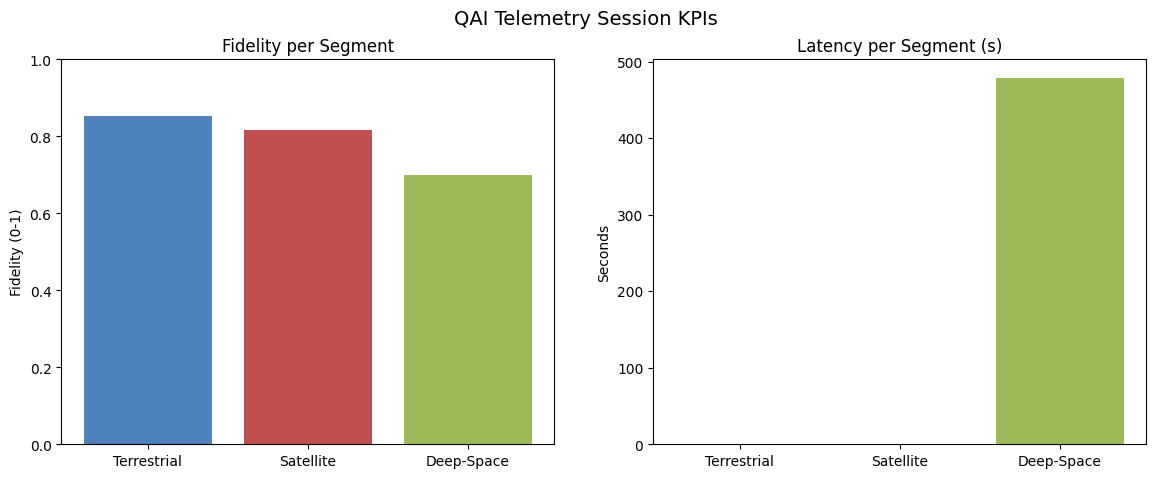

[2025-09-23T15:07:19.980322Z] [Session] [INFO] Saved KPI and logs to CSV files


/tmp/ipython-input-2372362072.py:27: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  t = datetime.utcnow().isoformat() + "Z"


In [2]:
# QAI Hybrid + QFT Telemetry Demo App (Colab-ready)
# - Power-On Self-Test (POST)
# - Sequence logging, handshakes, handovers, fallbacks, failure analysis
# - KPI tables and comparison table (QAI vs Classical)
# - Inline charts and CSV export
# Paste into a Google Colab cell and run.

import random
import time
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

# Optional ace_tools (Colab environment provided helper). If not present, display via print.
try:
    import ace_tools
except Exception:
    ace_tools = None

# -----------------------------
# Utility: logger for sequence events
# -----------------------------
sequence_log = []

def log_event(stage, message, status="INFO"):
    t = datetime.utcnow().isoformat() + "Z"
    sequence_log.append({"time": t, "stage": stage, "status": status, "message": message})
    print(f"[{t}] [{stage}] [{status}] {message}")

# -----------------------------
# QAI Product Simulators
# -----------------------------
class QAIProcessor:
    def __init__(self, name):
        self.name = name

    def self_test(self):
        # Return True if tests pass, False otherwise
        tests = {
            "photon_source": random.random() > 0.02,  # 98% pass
            "detectors": random.random() > 0.03,      # 97% pass
            "qec_accel": random.random() > 0.05       # 95% pass
        }
        all_pass = all(tests.values())
        log_event("POST", f"{self.name} POST results: {tests}", "PASS" if all_pass else "FAIL")
        return all_pass, tests

    def run_qec(self, fidelity):
        # Simulate QEC that slightly improves fidelity depending on resources
        delta = random.uniform(0.03, 0.08)
        improved = min(1.0, fidelity + delta)
        log_event("QEC", f"{self.name} applied QEC: {fidelity:.3f} -> {improved:.3f}")
        return improved

    def relativistic_correction(self, latency):
        # Simulate relativistic correction reducing effective schedule drift
        reduction = random.uniform(0.05, 0.25) * min(1.0, latency/500.0)
        corrected = max(0, latency - reduction * latency)
        log_event("RelativisticCorrection", f"{self.name} corrected latency: {latency:.2f}s -> {corrected:.2f}s")
        return corrected

class QAIOS:
    def __init__(self):
        self.slices = []
    def provision_slice(self, slice_type, domain, params=None):
        self.slices.append({"slice": slice_type, "domain": domain, "params": params or {}})
        log_event("Provision", f"Provisioned slice: {slice_type} in {domain} with params={params}")
    def attest_node(self, node_id):
        # simple attest simulation
        ok = random.random() > 0.01
        log_event("Attestation", f"Attestation for node {node_id}: {'OK' if ok else 'FAIL'}", "PASS" if ok else "FAIL")
        return ok

class QAIDatacenter:
    def __init__(self, entangled_pairs=150):
        self.entanglement_pool = entangled_pairs
        log_event("Datacenter", f"EaaS initialized with {self.entanglement_pool} entangled pairs")
    def allocate_entanglement(self, amount, purpose="general"):
        if self.entanglement_pool >= amount:
            self.entanglement_pool -= amount
            log_event("EaaS", f"Allocated {amount} pairs for {purpose}. Remaining {self.entanglement_pool}")
            return True
        else:
            log_event("EaaS", f"Allocation failed: requested {amount}, available {self.entanglement_pool}", "FAIL")
            return False
    def release_entanglement(self, amount):
        self.entanglement_pool += amount
        log_event("EaaS", f"Released {amount} pairs. New pool {self.entanglement_pool}")

# -----------------------------
# Domain Functions (simulate communication hops)
# -----------------------------
def terrestrial_segment(proc: QAIProcessor, os: QAIOS, dc: QAIDatacenter):
    stage = "Terrestrial"
    os.provision_slice("QKD", stage, {"priority":"high"})
    if not os.attest_node("terrestrial-node-1"):
        log_event(stage, "Node attestation failed, fallback to PQC", "ERROR")
        return {"fidelity": 0.0, "latency": None, "fallback":"PQC"}
    if not dc.allocate_entanglement(12, "terrestrial"):
        log_event(stage, "Entanglement allocation failed, fallback to PQC", "WARN")
        return {"fidelity": 0.0, "latency": None, "fallback":"PQC"}
    fidelity = random.uniform(0.75, 0.88)
    latency = random.uniform(0.005, 0.02)  # in seconds (5-20 ms)
    log_event(stage, f"Initial fidelity {fidelity:.3f}, latency {latency:.3f}s")
    fidelity = proc.run_qec(fidelity)
    return {"fidelity": fidelity, "latency": latency, "fallback": None}

def satellite_segment(proc: QAIProcessor, os: QAIOS, dc: QAIDatacenter, in_fidelity):
    stage = "Satellite"
    os.provision_slice("QKD-SAT", stage, {"constellation":"LEO", "priority":"high"})
    if not os.attest_node("sat-gateway-1"):
        log_event(stage, "Satellite attestation failed, attempt reroute or fallback", "ERROR")
        return {"fidelity": 0.0, "latency": None, "fallback":"REROUTE"}
    if not dc.allocate_entanglement(25, "satellite"):
        log_event(stage, "EaaS shortage at satellite", "WARN")
        return {"fidelity": 0.0, "latency": None, "fallback":"PQC"}
    # degrade fidelity due to free-space channel
    fidelity = max(0.0, in_fidelity - random.uniform(0.04, 0.12))
    latency = random.uniform(0.05, 0.25)  # 50-250 ms
    log_event(stage, f"Pre-QEC fidelity {fidelity:.3f}, latency {latency:.3f}s")
    fidelity = proc.run_qec(fidelity)
    return {"fidelity": fidelity, "latency": latency, "fallback": None}

def deep_space_segment(proc: QAIProcessor, os: QAIOS, dc: QAIDatacenter, in_fidelity):
    stage = "DeepSpace"
    os.provision_slice("RQKD", stage, {"window":"2026-07-01T00:00Z", "priority":"critical"})
    if not os.attest_node("deep-relay-1"):
        log_event(stage, "Deep-space node attestation failed", "ERROR")
        return {"fidelity": 0.0, "latency": None, "fallback":"DTN"}
    if not dc.allocate_entanglement(40, "deepspace"):
        log_event(stage, "Insufficient EaaS for deep-space", "FAIL")
        return {"fidelity": 0.0, "latency": None, "fallback":"DTN"}
    fidelity = max(0.0, in_fidelity - random.uniform(0.10, 0.22))
    latency = random.uniform(120, 600)  # in seconds (2-10 minutes typical)
    log_event(stage, f"Pre-correction fidelity {fidelity:.3f}, latency {latency:.1f}s")
    fidelity = proc.run_qec(fidelity)
    latency = proc.relativistic_correction(latency)
    return {"fidelity": fidelity, "latency": latency, "fallback": None}

# -----------------------------
# Power-On Self Test (POST)
# -----------------------------
def run_post(processor: QAIProcessor, os: QAIOS, dc: QAIDatacenter):
    log_event("POST", "Starting Power-On Self-Test sequence")
    ok, tests = processor.self_test()
    if not ok:
        log_event("POST", f"Processor POST failed: {tests}", "FAIL")
        return False
    # OS self-check (VMs)
    os_checks = {"QKD_VM": True, "RQKD_VM": True, "TelemetryVM": True}
    # simulate a minor chance of VM boot failure
    if random.random() < 0.02:
        os_checks["RQKD_VM"] = False
    if not all(os_checks.values()):
        log_event("POST", f"QAI OS VMs failed: {os_checks}", "FAIL")
        return False
    log_event("POST", "POST completed successfully", "PASS")
    return True

# -----------------------------
# Failure analysis & fallback handling
# -----------------------------
def handle_fallback(stage_result):
    if stage_result["fallback"] is None:
        return "OK"
    fb = stage_result["fallback"]
    if fb == "PQC":
        # simulate PQC fallback latency and success
        latency = random.uniform(0.1, 1.0)
        log_event("Fallback", f"PQC fallback engaged, added latency {latency:.2f}s", "WARN")
        return {"method":"PQC", "latency": latency}
    if fb == "REROUTE":
        # attempt reroute via alternative satellite
        success = random.random() > 0.2
        log_event("Fallback", f"Reroute attempt {'succeeded' if success else 'failed'}", "INFO" if success else "ERROR")
        return {"method":"REROUTE", "success": success}
    if fb == "DTN":
        # DTN store-and-forward
        delay = random.uniform(300, 3600)  # seconds
        log_event("Fallback", f"DTN store-and-forward selected, delay {delay/60:.1f} minutes", "WARN")
        return {"method":"DTN", "delay_s": delay}
    return {"method":"UNKNOWN"}

# -----------------------------
# Run the full telemetry session flow and capture KPIs and tables
# -----------------------------
def run_full_session(entangled_pairs=150):
    # initialize products
    processor = QAIProcessor("QAI-Proc-Edge-1")
    os = QAIOS()
    dc = QAIDatacenter(entangled_pairs=entangled_pairs)  # start pool

    # POST
    post_ok = run_post(processor, os, dc)
    if not post_ok:
        log_event("Session", "POST failed, aborting session and using PQC only", "FAIL")
        return None

    # Stage: Terrestrial
    ter = terrestrial_segment(processor, os, dc)
    fallback_ter = handle_fallback(ter)
    if isinstance(fallback_ter, dict) and fallback_ter.get("method") == "PQC":
        # PQC used instead, mark fidelity low but deliverable
        ter["fidelity"] = 0.0
        ter["latency"] = fallback_ter["latency"]

    # Stage: Satellite
    sat = satellite_segment(processor, os, dc, ter["fidelity"])
    fallback_sat = handle_fallback(sat)
    if isinstance(fallback_sat, dict) and fallback_sat.get("method") == "PQC":
        sat["fidelity"] = 0.0
        sat["latency"] = fallback_sat["latency"]
    elif isinstance(fallback_sat, dict) and fallback_sat.get("method") == "REROUTE" and not fallback_sat.get("success"):
        # if reroute failed -> PQC
        sat["fidelity"] = 0.0
        sat["latency"] = random.uniform(0.2,1.2)

    # Stage: Deep-space
    ds = deep_space_segment(processor, os, dc, sat["fidelity"])
    fallback_ds = handle_fallback(ds)
    if isinstance(fallback_ds, dict) and fallback_ds.get("method") == "DTN":
        # we will accept additional delay and set fidelity low for quantum part
        ds["fidelity"] = 0.0
        ds["latency"] = fallback_ds["delay_s"]

    # Aggregate KPIs and logs
    segments = ["Terrestrial", "Satellite", "Deep-Space"]
    fidelities = [ter["fidelity"], sat["fidelity"], ds["fidelity"]]
    latencies = [ter["latency"], sat["latency"], ds["latency"]]
    ent_pool_remaining = dc.entanglement_pool

    # Build KPI dataframe
    kpi_df = pd.DataFrame({
        "segment": segments,
        "fidelity": fidelities,
        "latency_s": latencies
    })

    # QAI vs Classical comparison table (sample metrics)
    comparison_df = pd.DataFrame([
        {"metric":"Fidelity (end-to-end)", "classical": round(random.uniform(0.40,0.55),3), "QAI": round(max(0, fidelities[-1]),3)},
        {"metric":"Latency (sec, sum)", "classical": round(random.uniform(100,500),2), "QAI": round(sum([x for x in latencies if x]),2)},
        {"metric":"Recovery & Resilience", "classical":"Manual reroute / human ops", "QAI":"Automated agents, EaaS, PQC fallback"},
        {"metric":"Resource efficiency (ent pairs used)", "classical":"N/A", "QAI": entangled_pairs - ent_pool_remaining}
    ])

    # Sequence log dataframe
    seq_df = pd.DataFrame(sequence_log)

    # Failure summary
    failures = seq_df[seq_df["status"].isin(["FAIL","ERROR"])].copy()
    failure_summary = failures[["time","stage","status","message"]]

    # Display artifacts
    if ace_tools:
        ace_tools.display_dataframe_to_user("KPI per segment", kpi_df)
        ace_tools.display_dataframe_to_user("QAI vs Classical Comparison", comparison_df)
        ace_tools.display_dataframe_to_user("Sequence Log (recent events)", seq_df.tail(20))
        ace_tools.display_dataframe_to_user("Failures", failure_summary)
    else:
        print("\nKPI per segment\n", kpi_df)
        print("\nQAI vs Classical Comparison\n", comparison_df)
        print("\nRecent Sequence Log\n", seq_df.tail(20))
        print("\nFailures\n", failure_summary)

    # Plots inline
    fig, axs = plt.subplots(1,2, figsize=(14,5))
    axs[0].bar(kpi_df["segment"], kpi_df["fidelity"], color=["#4f81bd","#c0504d","#9bbb59"])
    axs[0].set_ylim(0,1)
    axs[0].set_title("Fidelity per Segment")
    axs[0].set_ylabel("Fidelity (0-1)")

    axs[1].bar(kpi_df["segment"], kpi_df["latency_s"], color=["#4f81bd","#c0504d","#9bbb59"])
    axs[1].set_title("Latency per Segment (s)")
    axs[1].set_ylabel("Seconds")

    plt.suptitle("QAI Telemetry Session KPIs", fontsize=14)
    plt.show()

    # Return structured results
    return {
        "kpi_df": kpi_df,
        "comparison_df": comparison_df,
        "seq_df": seq_df,
        "failure_summary": failure_summary,
        "ent_pool_remaining": ent_pool_remaining
    }

# -----------------------------
# Execute the session simulation
# -----------------------------
if __name__ == "__main__":
    results = run_full_session(entangled_pairs=150)

    # If needed, save results to CSV for further inspection
    if results:
        results["kpi_df"].to_csv("kpi_segments.csv", index=False)
        results["comparison_df"].to_csv("comparison.csv", index=False)
        results["seq_df"].to_csv("sequence_log.csv", index=False)
        log_event("Session", "Saved KPI and logs to CSV files")


## **Concept and execution by Bhadale IT, code generated by ChatGPT **